# Trading Cards Evaluation Model

Mint Condition uses a machine learning model, specifically a Convolutional Neural Network (ResNet-18 trained from scratch), to predict the labels that experts assigned to training cards. In pilot experiments, this approach works much better than simply fine-tuning the top layer of a pretrained network, perhaps because low-level visual features such as scratches, printing defects, and rounded corners are very important for grading trading cards.

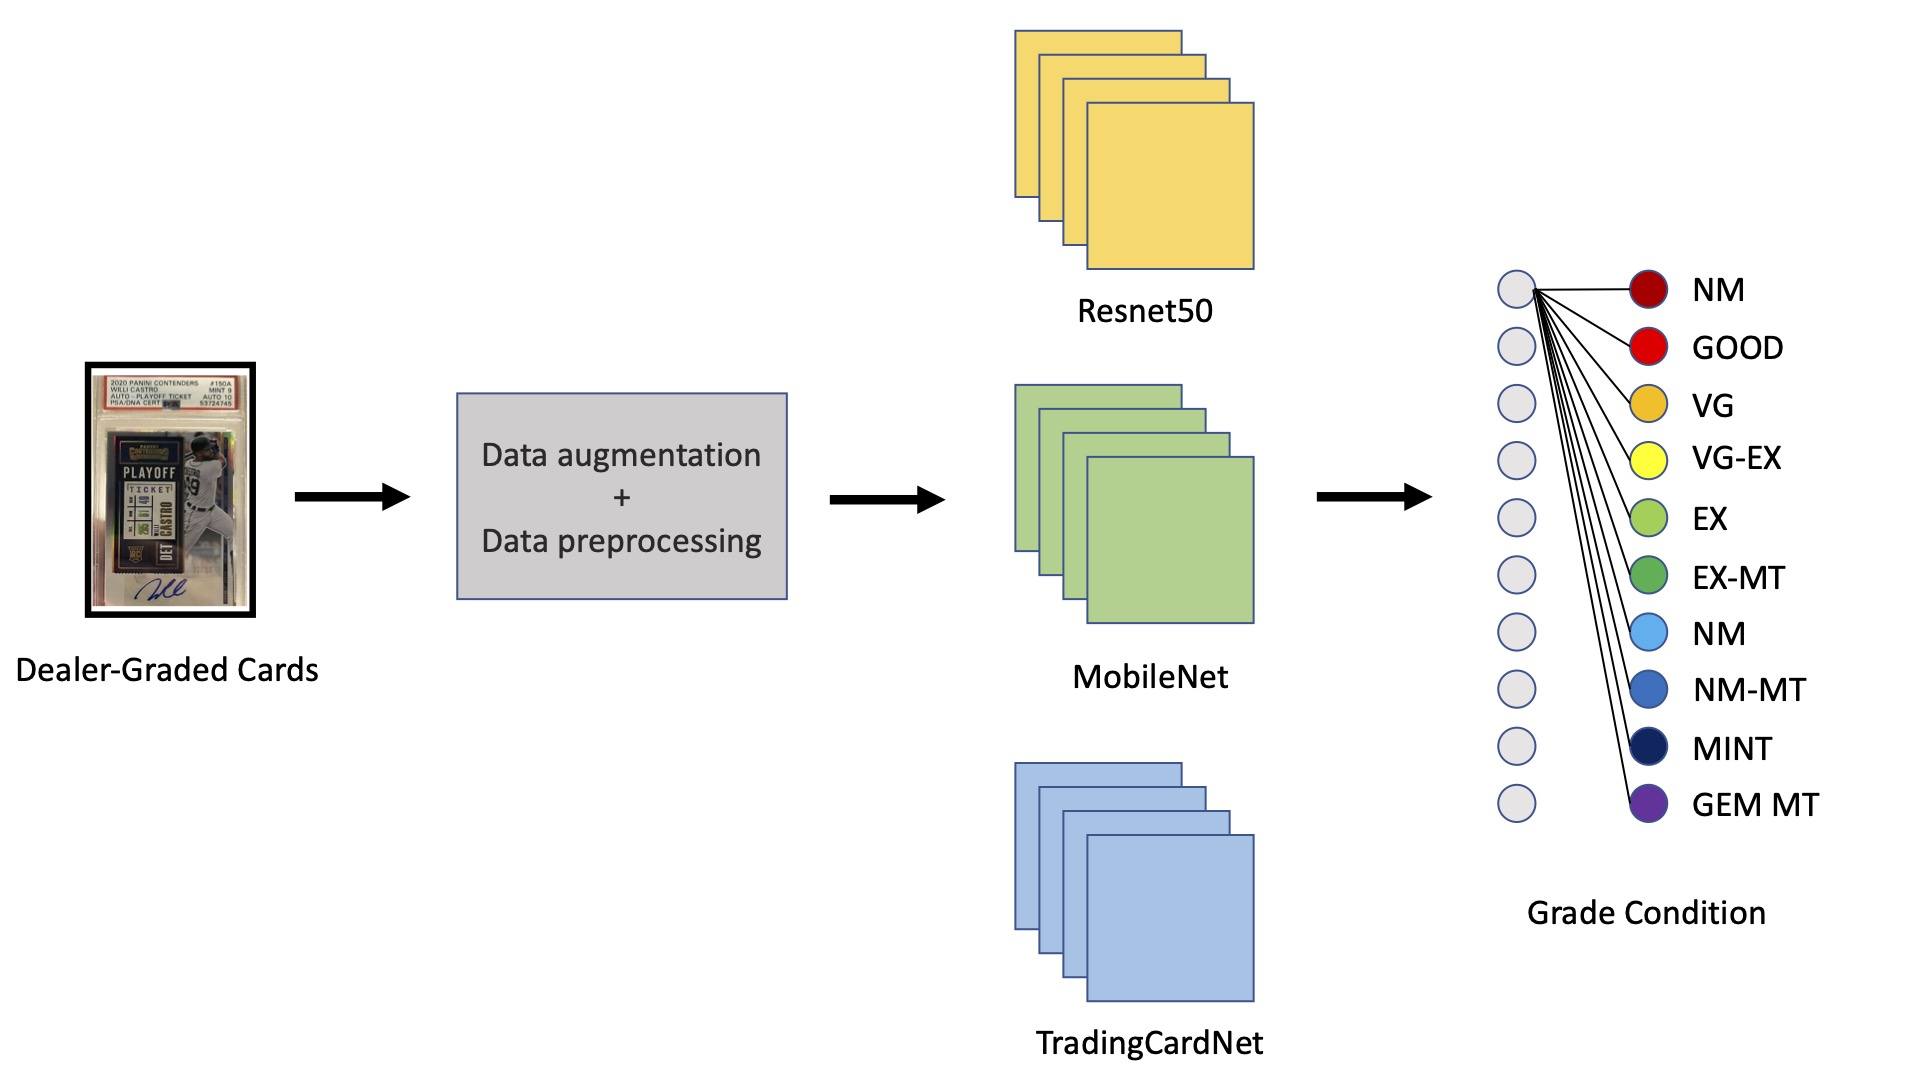

In [ ]:
! pip install flashtorch
! pip install neptune-client torch torchvision

  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26246 sha256=38440717e1f75af8e54c942caa2d87c1893cea1d0777ff97ddeae309added0a7
  Stored in directory: /root/.cache/pip/wheels/e8/bc/36/9ac3236719be1f1c6d1d758fc5e404410fe17027dd80d1d06d
Successfully built flashtorch
     |████████████████████████████████| 287 kB 8.8 MB/s 
     |████████████████████████████████| 829 kB 56.1 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 180 kB 69.7 MB/s 
     |████████████████████████████████| 131 kB 54.4 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 8.5 MB 39.4 MB/s 
     |████████████████████████████████| 138 kB 58.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 127 kB 57.0 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 130 kB 92.8 MB/s 
  Created wheel fo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! cp /content/drive/MyDrive/mint-condition/imgs.zip /content
# ! unzip /content/imgs.zip -d /content/

^C
Archive:  /content/imgs.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/imgs.zip or
        /content/imgs.zip.zip, and cannot find /content/imgs.zip.ZIP, period.


## Try to add neptune into our training pipeline

In [ ]:
import neptune.new as neptune

run = neptune.init(
    project="pinchennnn/Final-tradingcard",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjNmEyZmQwOC0wMDgyLTQ1NzQtYjkzOS0zMjNiYTc2Y2ZlMzQifQ==",
)

https://app.neptune.ai/pinchennnn/Final-tradingcard/e/FIN-44
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
from google.colab import drive
from scipy.stats import spearmanr
import random
import csv
from sklearn.model_selection import train_test_split
import copy
import time
import numpy as np
import os
import pickle 
import matplotlib.pyplot as plt
import pathlib
import torch
import pandas as pd
from torchvision import transforms
import torchvision.models as models
from torchvision import datasets 
from torch.utils import data 
from pathlib import Path
from PIL import Image
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from flashtorch.saliency import Backprop
from scipy.ndimage.filters import gaussian_filter
from torchsummary import summary
import torch.nn as nn

In [ ]:
ebay_dataset_w_label_path = "/content/drive/MyDrive/mint-condition/imgs/imgs"
# ebay_dataset_w_label_path = "/content/imgs"
ebay_dataset_partition_path = "/content/drive/MyDrive/mint-condition/partitioned"
ebay_dataset_label_path = "/content/drive/MyDrive/mint-condition/card_labels_for_pandas.csv"
workspace_path = "/content/drive/MyDrive/output/"
str_labels = ["PR", "GOOD", "VG", "VG-EX", "EX", "EX-MT", "NM", "NM-MT", "MINT", "GEM MT"]

## Data Augmentation & Data Preprocessing

At first, we need to deal with the input data. Because trading card has some problem including data scarcity and insufficient data diversity, we use data augmentation to make sure the dataset is large enough for this task.

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, list_IDs, apply_rotations=False):
        """
        Args:
            list_IDs (str []) file paths.
            labels (str []) target labels.
            apply_rotations (bool) : if True then randomly rotate images. (NOTE! This should be FALSE for testing data.)
        """
        # self.labels = labels # dictionary. key=fname, value=integer lbl.
        self.labels = pd.read_csv(ebay_dataset_label_path).set_index('filename')
        self.labels = self.labels['original rating'].to_dict()
        self.list_IDs = list_IDs # list of filenames.
        self.X = torch.from_numpy(np.random.random((3, 255, 255))).float()
        self.y = 0
        # self.list_IDs = list(ebay_dataset_w_label_path.glob('*.jpg'))
        self.apply_rotations = apply_rotations
        self.rotation_fn = transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=90, shear=90, translate=(0.5, 0.5), scale=(0.7, 0.7)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        self.normalization = transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        # Make ML_images directory and subdirectories.
        base_p = os.path.join(workspace_path, "data", "ml_images")
        if not os.path.exists(base_p):
            pathlib.Path(base_p).mkdir(parents=True, exist_ok=True)
            for condition in str_labels:
                p = os.path.join(base_p, condition)
                pathlib.Path(p).mkdir(parents=True, exist_ok=True)

    def __len__(self):
        return len(self.list_IDs)


    def load_and_preprocess_img(self, img_p, apply_rotations=False):
        """ 
        load and preprocess img, optionally applying rotations parameters.
        
        Args:
            img_p (str): path to image.
            apply_rotations (bool): if True apply rotations to the image.    
                                    should be false to all testing.
        Returns:
            X (torch tensor): Image as torch tensor of shape (3, 255, 255)
        """

        img = Image.open(img_p)

        # Resize image, do normalization, optionally rotate.
        if apply_rotations:
          X = self.rotation_fn(img)
        else:
          X = self.normalization(img)

        return X

    def __getitem__(self, index):

        try:

            # Select sample.
            remote_p = self.list_IDs[index]

            # Get label.
            y = self.labels[remote_p] - 1

            # If the image does not exist locally, get it from S3.
            # local_p = os.path.join(workspace_path, "data", "ml_images", remote_p)
            # local_p = ebay_dataset_w_label_path + '/' + str(remote_p)
            local_p = Path(ebay_dataset_w_label_path).joinpath(remote_p)
            if not os.path.exists(local_p):
              print(f"{local_p} doesn't exist")
                # self.download_from_s3(remote_p)

            # Load image and reshape to torch tensor of shape (3, 255, 255)
            X = self.load_and_preprocess_img(local_p, apply_rotations=self.apply_rotations) # torch tensor.
            self.X = X
            self.y = y

        except Exception as e:
            print(e)
            print("exception loading data..using random image, label instead")
            # X = np.random.random((3, 255, 255))
            # X = torch.from_numpy(X).float()
            # y = 0
            X = self.X
            y = self.y

        return X, y

## Built and Train on ResNet, MobileNet, and Our New Model - TradingCardNet.

First, set up the parameters.

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    """
    Helper function to freeze layers when fine-tuning a model.
    Sets all neurons except those in a top layer to not return gradient.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def reenable_gradients(model):
    """
    Helper function to re-enable gradients for all neurons in the model. 
    Useful for saliency maps. Counterpart to set_parameter_requires_grad()
    """
    for param in model.parameters():
      param.requires_grad = True
    return model

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    """
    Helper function to initialize pretrained models in Pytorch.
    """

    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
      """ 
      Resnet18
      """
      model_ft = models.resnet18(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = torch.nn.Linear(512, num_classes)
      input_size = 224

    elif model_name == "alexnet":
      """ 
      Alexnet
      """
      model_ft = models.alexnet(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier[6].in_features
      model_ft.classifier[6] = torch.nn.Linear(num_ftrs,num_classes)
      input_size = 224

    elif model_name == "vgg":
      """ 
      VGG19_bn
      """
      model_ft = models.vgg19_bn(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier[6].in_features
      model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
      input_size = 224

    elif model_name == "squeezenet":
      """ 
      Squeezenet
      """
      model_ft = models.squeezenet1_0(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
      model_ft.num_classes = num_classes
      input_size = 224

    elif model_name == "densenet":
      """ 
      Densenet
      """
      model_ft = models.densenet121(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier.in_features
      model_ft.classifier = nn.Linear(num_ftrs, num_classes)
      input_size = 224

    elif model_name == "inception":
      """ 
      Inception v3
      Be careful, expects (299,299) sized images and has auxiliary output
      """
      model_ft = models.inception_v3(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      # Handle the auxilary net
      num_ftrs = model_ft.AuxLogits.fc.in_features
      model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
      # Handle the primary net
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs,num_classes)
      input_size = 299

    else:
      print("Invalid model name, exiting...")
      exit()

    return model_ft, input_size


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, device="cpu"):
    """ 
    Helper function to train model in PyTorch
 
    Args:
        model (pytorch model object)
        dataloaders (pytorch dataloader objects)
        criterion (pytorch loss function)
        optimizer (pytorch optimizer)
        num_epochs (int)
        is_inception (bool)
        device (str): "cpu" or "cuda:0"
    """

    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initiailize a file to track accuracy over epochs.
    acc_of_p = os.path.join(workspace_path, "model_accuracy.csv")
    acc_of = open(acc_of_p, "w", newline="")
    header = ["epoch", "phase", "accuracy", "F", "R"]
    w = csv.writer(acc_of)
    w.writerow(header)
    lbl_to_idx = {lbl: i for i, lbl in enumerate(str_labels)}

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'test']:
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0.0
        ypreds = []
        ytrues = []

        # Iterate over data.
        batch_num = 0
        for inputs, labels in dataloaders[phase]:
          labels = list(labels)
          inputs = torch.tensor(inputs).clone().detach().to(device)
          labels = torch.tensor(labels).clone().detach().to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            """
            Get model outputs and calculate loss
            Special case for inception because in training it has an auxiliary output. In train
            mode we calculate the loss by summing the final output and the auxiliary output
            but in testing we only consider the final output.
            """
            if is_inception and phase == 'train':
              # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
              outputs, aux_outputs = model(inputs)
              loss1 = criterion(outputs, labels)
              loss2 = criterion(aux_outputs, labels)
              loss = loss1 + 0.4*loss2
            else:
              outputs = model(inputs)
              loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            preds = preds.clone().detach().to('cpu')
            # Update model if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data.cpu())
          F = f1_score(preds.numpy(), labels.data.cpu().numpy(), average="micro")
          ypreds.extend(list(preds.numpy()))
          ytrues.extend(list(labels.data.clone().detach().to('cpu').numpy()))

          # counter.
          batch_num += 1

          if batch_num % 1 == 0:
            correct = float(torch.sum(preds == labels.data.cpu()))
            incorrect = float(torch.sum(preds != labels.data.cpu()))
            perc_correct = 100 * correct / (correct + incorrect)
            msg = """
            epoch {} batch {} : percent correct={:.4f} F={:.4f}
            """.format(epoch, batch_num, perc_correct, F)

            # rank correlation of predicted, actual.
            rho, p = spearmanr(preds.numpy(), labels.data.cpu().numpy())
            # print("correlation of pred, actual: rho = {:.4f}".format(rho))

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        epoch_F = f1_score(ypreds, ytrues, average="micro")
        epoch_R = pearsonr(ypreds, ytrues)[0]
        run["training/batch/loss"].log(epoch_loss)
        run["training/batch/acc"].log(epoch_acc)
        run["training/batch/f1_score"].log(epoch_F)
        run["training/batch/pearsonr_score"].log(epoch_R)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'test':
          val_acc_history.append(epoch_acc)

        # Write latest train and test accuracies to output file.
        out = [epoch, phase, epoch_acc.numpy(), epoch_F, epoch_R]
        w.writerow(out)
        acc_of.flush()

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # Pickle the model after end of epoch.
      of_p = os.path.join(workspace_path, "models", "latest_model.p")
      with open(of_p, "wb") as of:
        pickle.dump(model, of)
      print("wrote {}".format(of_p))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # close output file.
    with open(of_p, "wb") as of:
      of.flush()
      of.close()
    print("wrote {}".format(acc_of_p))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


def train_CNN_model(num_epochs=10, load_latest_model=False):
    """
    Train a CNN to classify card pictures.

    Parameters:
        num_classes (int) : controls # of output neurons.
        load_latest_model (boolean) : 
            if True then use latest model from models/latest_model.p      
            if False then start with a pretrained ImageNet model.
    """ 

    # Use CUDA if available.
    use_cuda = torch.cuda.is_available()
    print("check if CUDA can be used -> {}".format(use_cuda))
    device = parameters["device"]
    
    # Optimizer parameters
    lr = parameters["lr"]
    momentum = 0.9
    weight_decay = 1.0e-4

    # Parameters
    params = {
        "batch_size" : parameters["batch_size"],
        "shuffle" : True,
        "num_workers" : 4
    }

    # Datasets.
    print("load train/test partition and labels")
    partition_p = os.path.join(ebay_dataset_partition_path, "partition.p")
    labels_p = os.path.join(ebay_dataset_partition_path, "labels.p")
    
    partition = pickle.load(open(partition_p, "rb"))
    print('train: ', len(partition["train"]))
    print('test: ', len(partition["test"]))
    count = 0
    for i in partition["train"]:
      count += 1
    print('train: ', count)
    count = 0
    for i in partition["test"]:
      count += 1
    print('test: ', count)

    # Create generators over train data and test data.
    print("create generators over train, test data")
    train_set = Dataset(partition["train"], apply_rotations=True) # do rotate train data.
    train_g = data.DataLoader(train_set, **params)

    test_set = Dataset(partition["test"], apply_rotations=False) # don't rotate test data.
    test_g = data.DataLoader(test_set, **params)

    # Initialize pretrained model 
    # Replace top layer with a layer of (num_classes) outputs
    # Note that setting feature_extract to False means we fine-tune
    # the whole model, True we finetune only top layer.
    if load_latest_model:
      print("load pickled latest_model.p")
      model_p = os.path.join(workspace_path, "models", "latest_model.p")
      model = pickle.load(open(model_p, "rb"))
    else:
      model, _ = initialize_model(
          model_name = parameters["model_type"],
          num_classes = parameters["num_classes"],
          feature_extract = True, # if True only finetune top layer.
          use_pretrained = False
      )
    
    # model = ResNet18()
    # model.module.linear = nn.Linear(model.module.linear.in_features, 10)
    # input_size = 224
    model.to(device)

    # Initialize optimizer, loss criterion.
    # TODO[Pin]: Try different optimizers and loss functions.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                                 betas=(0.9, 0.999), 
                                 eps=1e-08, 
                                 weight_decay=0)
    criterion = torch.nn.CrossEntropyLoss()

    run["config/model"] = type(model).__name__
    run["config/criterion"] = type(criterion).__name__
    run["config/optimizer"] = type(optimizer).__name__

    # Train model.
    model, history = train_model(
      model=model,
      dataloaders = {"train" : train_g, "test" : test_g},
      criterion=criterion,
      optimizer=optimizer,
      num_epochs=1,
      is_inception=False,
      device=device
    )

    model = reenable_gradients(model)

    model, history = train_model(
      model=model,
      dataloaders = {"train" : train_g, "test" : test_g},
      criterion=criterion,
      optimizer=optimizer,
      num_epochs=num_epochs,
      is_inception=False,
      device=device
    )
     
    # Pickle best performing model.
    of_p = os.path.join(workspace_path, "models", "best_model.p")
    with open(of_p, "wb") as of:
      pickle.dump(model, of)
    print("wrote {}".format(of_p))

    # # Pickle history of best performing model.
    of_p = os.path.join(workspace_path, "models", "history.p")
    with open(of_p, "wb") as of:
      pickle.dump(history, of)
    print("wrote {}".format(of_p))

In [ ]:
parameters = {
    "lr": 1.0e-3,
    "batch_size": 16,
    "num_classes": 10,
    "model_type": "vgg",
    "model_filename": "basemodel",
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [ ]:
run["config/hyperparameters"] = parameters

Then, select the model for trading card evaluation and train.

In [ ]:
# torch.cuda.empty_cache()
train_CNN_model(num_epochs=40, load_latest_model=False)

## Building the Evaluation Metrics & Model Evaluation

Finally, we need to  evaluate our model. In this section, we seperate our evaluation process into two steps: build evaluation metrics and do the model evaluation.

TODO[Pin]: How to build an evaluation metric? There are some points: 1. different card conditions may have some relations with others.

In [ ]:
def load_and_preprocess_img(img_p):
    """ helper function to load and preprocess img
        returns shape (1, 3, 255, 255)
        important!
        use the Dataset class to preprocess images for training.
        use this only for saliency map due to slight shape different.y

        Args:
            img_p (str): path to image.
        Returns:
            X (torch tensor): Image as torch tensor of shape (64, 3, 255, 255)
    """

    # Load image and reshape to (3, 255, 255)
    img = Image.open(img_p)
    img = img.resize((255, 255), Image.ANTIALIAS)

    # Cast to torch tensor.
    X = np.array(img) # (255, 255, 3) numpy
    X = X.reshape((1, 255, 255, 3))
    X = X / 255
    X = X.swapaxes(2, 3) # (64, 255, 3, 255)
    X = X.swapaxes(1, 2) # (64, 3, 255, 255) numpy
    X = torch.from_numpy(X).float() # (64, 3, 255, 255) torch

    return X

def saliency_map(model, img_p):
    """
    Return saliency map over the image : shape (255, 255)
    """

    # Load and preprocess image.
    X = load_and_preprocess_img(img_p).to("cuda:0") # (3, 255, 255 torch tensor)
    X.requires_grad_() # This is critical to actually get gradients.

    # Predict grade and get gradient. Use flashtorch library.
    model.train()
    with torch.set_grad_enabled(True):
        backprop = Backprop(model) # flashtorch.saliency Backprop object.
        gradients = backprop.calculate_gradients(X, take_max=True, guided=False)# (1, 255, 255)
        

    # Cast image, saliency maps to numpy arrays.
    X = X.detach() # must 'detach' from gradients before slicing.
    img_np = X.numpy()[0] # (3, 255, 255)
    img_np = img_np.swapaxes(0, 1) # (255, 3, 255)
    img_np = img_np.swapaxes(1, 2) # (255, 255, 3)
    saliency_map_np = gradients.numpy()[0] # (255, 255)
    print(max(np.max(saliency_map_np, axis=0)))
    print(saliency_map_np)
    print(img_np.shape)
    print(saliency_map_np.shape)

    # Smooth heatmap.
    saliency_map_np = gaussian_filter(saliency_map_np, sigma=10)

    # Plot image and overlay saliency map.
    heatmap = sns.heatmap(saliency_map_np, alpha=0.5)
    heatmap.imshow(img_np, cmap="YlGnBu")
    plt.show()

    return saliency_map_np

model_p = os.path.join("/content/drive/MyDrive/output/models", "best_model.p")
model = pickle.load(open(model_p, "rb")).to('cuda:0')
reenable_gradients(model) # e.g., disable fine-tuning mode
img_p = os.path.join("/content/drive/MyDrive/mint-condition/imgs/imgs", 
                     "grade_1_page_28_id_9.jpg")
sm = saliency_map(model, img_p)


In [ ]:
# Parameters
params = {
    "batch_size" : 1,
    "shuffle" : True,
    "num_workers" : 4
}
print("load train/test partition and labels")
partition_p = os.path.join(ebay_dataset_partition_path, "partition.p")
labels_p = os.path.join(ebay_dataset_partition_path, "labels.p")

partition = pickle.load(open(partition_p, "rb"))
train_set = Dataset(partition["train"], apply_rotations=True) # do rotate train data.
train_g = data.DataLoader(train_set, **params)


model_p = os.path.join("/content/drive/MyDrive/output/models", "best_model.p")
model = pickle.load(open(model_p, "rb")).to('cpu')
# reenable_gradients(model)
model.eval()

for i in range(100):
  img, l = next(iter(train_g))
  pred = model(img.to('cpu')).argmax(dim=1)
  img.requires_grad_()
  model.requires_grad = True
  print(pred)
  print(l)
  print('---')
# model.train()
# with torch.set_grad_enabled(True):
#     backprop = Backprop(model) # flashtorch.saliency Backprop object.
#     gradients = backprop.calculate_gradients(img.to('cpu'), take_max=True, guided=False)
